# Mounting Google Drive to Notebook

In [ ]:
# Mount Google Drive to Google Colab so that you have a more permanent storage accessible - to load data and save trained models.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Adjusting your File Structure in Drive.
Comment it out once it is done, Only to be run once.

In [ ]:
# This is a one time step where we are basically taking the dataset and putting it in three different folders - train, validation and test.
from pathlib import Path
import shutil
from tqdm import tqdm
import os

image_dir = "/content/drive/My Drive/helmet-dataset/images"
anno_dir = "/content/drive/My Drive/helmet-dataset/annotations"

path_annotations = []
for i in Path(anno_dir).glob('*.xml'):
    path_annotations.append(i)
path_annotations = sorted(path_annotations) #contains path to 5000 annots

path_images = []
for i in Path(image_dir).glob('*.png'):
    path_images.append(i)
path_images = sorted(path_images) #contains path to 5000 images


# Split data : 80% Train, 10% Val & 10% Test.
path_train_annot = path_annotations[:4000]
path_train_images = path_images[:4000]

path_val_annot = path_annotations[4000:4500]
path_val_images = path_images[4000:4500]

path_test_annot = path_annotations[4500:5000]
path_test_images = path_images[4500:5000]


# Creating directories to put train, val & test data.
os.makedirs('/content/drive/My Drive/helmet_dataset/train/annotations',exist_ok = True)
os.makedirs('/content/drive/My Drive/helmet_dataset/train/images', exist_ok = True)
os.makedirs('/content/drive/My Drive/helmet_dataset/val/annotations', exist_ok = True)
os.makedirs('/content/drive/My Drive/helmet_dataset/val/images', exist_ok = True)
os.makedirs('/content/drive/My Drive/helmet_dataset/test/annotations', exist_ok = True)
os.makedirs('/content/drive/My Drive/helmet_dataset/test/images', exist_ok = True)
os.makedirs('/content/drive/My Drive/helmet_dataset/savedmodel', exist_ok = True)


#Copy data into train, val & test folders
for i, (path_annot, path_img) in tqdm(enumerate(zip(path_train_annot, path_train_images))):
    shutil.copy(path_img, '/content/drive/My Drive/helmet_dataset/train/images/' + path_img.parts[-1])
    shutil.copy(path_annot, '/content/drive/My Drive/helmet_dataset/train/annotations/' + path_annot.parts[-1])

for i, (path_annot, path_img) in tqdm(enumerate(zip(path_val_annot, path_val_images))):
    shutil.copy(path_img, '/content/drive/My Drive/helmet_dataset/val/images/' + path_img.parts[-1])
    shutil.copy(path_annot, '/content/drive/My Drive/helmet_dataset/val/annotations/' + path_annot.parts[-1])

for i, (path_annot, path_img) in tqdm(enumerate(zip(path_test_annot, path_test_images))):
    shutil.copy(path_img, '/content/drive/My Drive/helmet_dataset/test/images/' + path_img.parts[-1])
    shutil.copy(path_annot, '/content/drive/My Drive/helmet_dataset/test/annotations/' + path_annot.parts[-1])

# Data Preparation & Making it PyTorch Compatible to use Dataloader Feature

In [ ]:
import torch
from pathlib import Path
import shutil
from tqdm import tqdm
import os

BATCH_SIZE = 4 #increase / decrease according to memory, generally smaller batch helps in fast & more updates. but less accurate update.
NUM_WORKERS = 2

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# training images and XML files directory
TRAIN_DIR = '/content/drive/My Drive/helmet_dataset/train'
# validation images and XML files directory
VALID_DIR = '/content/drive/My Drive/helmet_dataset/val'

# classes: 0 index is reserved for background
CLASS_NAME = ['__background__', 'helmet', 'head', 'person']
NUM_CLASSES = len(CLASS_NAME)

In [ ]:
# Apply transform to image
import albumentations as A #new method, customizable transformations
from albumentations.pytorch import ToTensorV2

# define the training tranforms
def get_train_transform():
    return A.Compose([
        A.Resize(415,415),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0), # p here denotes the probability
        ], bbox_params={'format': 'pascal_voc','label_fields': ['labels']}
    )

# define the validation transforms (validation data shud not be augmented)
def get_valid_transform():
    return A.Compose([
        A.Resize(415,415),
        ToTensorV2(p=1.0),
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )

# The collate_fn() will help us take care of tensors of varying sizes while creating
# the training and validation data loaders.
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

In [ ]:
# Prepare the pytorch dataset
from torch.utils.data import Dataset, DataLoader
import glob, matplotlib.pyplot as plt, matplotlib.patches as patches
import xml.etree.ElementTree as ET
from pathlib import Path

# foll is the class to create pytorch dataset from images(.png) & annotations(.xml)

class SafetyHelmDataset(Dataset):
    def __init__(self, dir_path, class_name, transforms=None):
        self.dir_path = dir_path
        self.class_name = class_name
        self.transforms = transforms

        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/images/*.png")
        self.all_images = sorted(self.image_paths)


    def __getitem__(self, idx: int):
        image_name = self.all_images[idx] #reading image one by one

        image = plt.imread(image_name) #read the image
        image /= 255.0 #normalize pixels b/w 0 & 1

        # capture the corresponding xml file for getting annotations
        annot_filepath = os.path.join(f'{self.dir_path}/annotations/', Path(image_name).parts[-1][:-4] + '.xml')

        boxes, labels = [], []
        root = ET.parse(annot_filepath).getroot() #reading xml file

        # extracting box coordinates from xml annotations
        for member in root.findall('object'):
            # map the current object name to classes to get the label index
            labels.append(self.class_name.index(member.find('name').text))

            # (xmin, ymin) are left corner coordinates & (xmax, ymax) are right corner coordinates
            xmin = int(member.find('bndbox').find('xmin').text)
            ymin = int(member.find('bndbox').find('ymin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            ymax = int(member.find('bndbox').find('ymax').text)

            boxes.append([xmin, ymin, xmax, ymax])

        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # prepare the final target dict
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        image_id = torch.tensor([idx])
        target['image_id'] = image_id

        # apply image transforms
        if self.transforms:
            sample = self.transforms(image=image, bboxes=target['boxes'], labels=labels)
            image = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return image, target #these are the o/p of this class


    def __len__(self):
        return len(self.all_images)

In [ ]:
train_dataset = SafetyHelmDataset(TRAIN_DIR, CLASS_NAME, get_train_transform())
valid_dataset = SafetyHelmDataset(VALID_DIR, CLASS_NAME, get_valid_transform())

In [ ]:
#In PyTorch, a DataLoader is part of the torch.utils.data module that provides flexible and efficient facilities to load and preprocess our data.
#It wraps around a dataset object (which should be an instance of a subclass of Dataset) and provides an iterable over the dataset.

train_loader = DataLoader( #for loading data in batches, pytorch requires image as channel 1st e.g (3(channel),640(ht),480(wd))
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

# Cells to Understand & Visualize the Data
(Not a part of the Main Code)

In [ ]:
%%time
from tqdm import tqdm
# Initialize a dictionary to count occurrences of each class
class_occurrences_train = {class_name: 0 for class_name in CLASS_NAME}
class_occurrences_val =   {class_name: 0 for class_name in CLASS_NAME}

# Here observing the training & test data
# Iterate through the dataset and count occurrences
for _, target in tqdm(train_dataset):
    labels = target['labels'].tolist()
    for label in labels:
        class_occurrences_train[CLASS_NAME[label]] += 1

for _, target in tqdm(valid_dataset):
    labels = target['labels'].tolist()
    for label in labels:
        class_occurrences_val[CLASS_NAME[label]] += 1

# Print the label distribution
print("Label Distribution for Training:")
for class_name, occurrences in class_occurrences_train.items():
    print(f"{class_name}: {occurrences} occurrences")

print("Label Distribution for Validation:")
for class_name, occurrences in class_occurrences_val.items():
    print(f"{class_name}: {occurrences} occurrences")

100%|██████████| 500/500 [03:51<00:00,  2.16it/s]

Label Distribution for Training:
__background__: 0 occurrences
helmet: 15033 occurrences
head: 4631 occurrences
person: 566 occurrences
Label Distribution for Validation:
__background__: 0 occurrences
helmet: 1986 occurrences
head: 581 occurrences
person: 95 occurrences
CPU times: user 1min 11s, sys: 5.82 s, total: 1min 16s
Wall time: 17min 12s


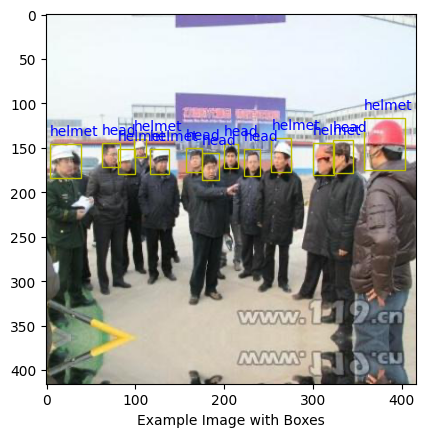

In [ ]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image

def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    boxes = [] # here boxes is a list of dictionaries

    for obj in root.findall('.object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        boxes.append({'name': name, 'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax})

    return boxes

def plot_image_with_boxes(image_path, annotation_boxes):
    # Read the image
    image = Image.open(image_path)

    # Plot the image
    plt.imshow(image)

    # Plot the bounding boxes
    ax = plt.gca()
    for box in annotation_boxes:

        xmin, ymin, xmax, ymax = box['xmin'], box['ymin'], box['xmax'], box['ymax']
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='y', facecolor='none')
        ax.add_patch(rect)
        plt.text(xmin, ymin - 10, box['name'], color='b')
        plt.xlabel('Example Image with Boxes')

    plt.show()

# Example usage
image_path = "/content/drive/My Drive/helmet_dataset/train/images/hard_hat_workers0.png"
xml_file = "/content/drive/My Drive/helmet_dataset/train/annotations/hard_hat_workers0.xml"

annotation_boxes = parse_xml(xml_file)
'''
if want to print a particular class only.
list1=[]
for dict in annotation_boxes:
    if dict['name']== 'head':
      list1.append(dict)
list1
'''
plot_image_with_boxes(image_path, annotation_boxes)


# Declaring & Instantiating Model Architecture
# Using Resnet50 Backbone

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def create_model(num_classes):
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)

# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]

# define the optimizer & scheduler,

# Generally Rule of Thumb is to Use SGD+Momentum Or Adam with a Annealing Learning Rate Scheduler.
# (this is the simple optimizer you can use other optimizer with callbacks for complex dataset)

# taking mostly default values for a possible optimal solution.
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.5,last_epoch=-1)

# Note:- Here, I also tried with Adam with larger no. of epochs, but it comes out to be that SGD works better than Adam on this specific task.

# **Training the Model**
# SGD with Momentum is used along with Step LR Scheduling.


1. SGD Hyperparameters

*   Learning Rate$(η)$ = 0.001
*   Momentum $(β)$ = 0.9
*   Weight Decay$(λ)$ (L2 Regularizer) = 0.0005

2.  Step LR Scheduling Hyperparameters

*   Step Size = 5
*   Gamma $(γ)$ = 0.5

3. No. of Epochs = 16

4. Batch Size = 4






In [ ]:
# function for running training iterations
from tqdm import tqdm

def train(train_data_loader, model):
    print('Training...')
    global train_itr
    global train_loss_list

    # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    # criterion = torch.nn.BCELoss(size_average=True)

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad() #####
        images, targets = data #####

        images = list(image.to(DEVICE) for image in images) #####
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets] #####

        loss_dict = model(images, targets) #####
        losses = sum(loss for loss in loss_dict.values()) #####
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward() #####
        optimizer.step() #####
        train_itr += 1 #####

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

In [ ]:
# The validation function returns a similar list containing the loss values
# for all the completed iterations

# function for running validation iterations
def validate(valid_data_loader, model):
    print('Validating...')
    global val_itr
    global val_loss_list

    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))

    for i, data in enumerate(prog_bar):
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

In [ ]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(self, best_valid_loss=float('inf')):
        self.best_valid_loss = best_valid_loss

    def __call__(self, current_valid_loss, epoch, model, optimizer, scheduler):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss:.3f}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                }, '/content/drive/My Drive/helmet_dataset/savedmodel/best_model.pth')


# function to save the model after each epoch and after training ends
def save_model(epoch, model, optimizer, scheduler):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                }, '/content/drive/My Drive/helmet_dataset/savedmodel/last_model.pth')
epoch=0

In [ ]:
# initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1

# train and validation loss lists to store loss values of all
# iterations till end and plot graphs for all iterations
train_loss_list = []
val_loss_list = []

# initialize SaveBestModel class
save_best_model = SaveBestModel()

NUM_EPOCHS = 16 # number of epochs to train for

# start the training epochs
for epoch in range(epoch, NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()

    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)

    print(f'Current Learning Rate: {scheduler.get_last_lr()}') # this prints the lr used in training that specific epoch
    scheduler.step()

    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")

    # save the best model till now if we have the least loss in the current epoch
    save_best_model(val_loss_hist.value, epoch, model, optimizer, scheduler) # it will call the in-built __call__ function.
    # when you create an instance of a Class defined with __call__ func. also
    # you can directly call the __call__ func. using only the instance name
    # instance = Class(); instance(a,b) it is subsitute for instance.call(a,b)

    # save the current epoch model
    save_model(epoch, model, optimizer, scheduler)

    # save is done after scheduler.step()
    # as info. related to scheduler is saved in terms of steps, if saved before using scheduler.step(), it would cause training one more epoch
    # in a specific lr, here step size is 5, so when resumed training it will train one more epoch on that lr causing 6 to train using that
    # particular lr, which will be wrong.



EPOCH 1 of 16
Training...


Loss: 0.5052: 100%|██████████| 1000/1000 [14:12<00:00,  1.17it/s]


Validating...


Loss: 0.5307: 100%|██████████| 125/125 [01:50<00:00,  1.13it/s]


Current Learning Rate: [0.01]
Epoch #1 train loss: 0.590
Epoch #1 validation loss: 0.644

Best validation loss: 0.644

Saving best model for epoch: 1


EPOCH 2 of 16
Training...


Loss: 0.6217: 100%|██████████| 1000/1000 [12:44<00:00,  1.31it/s]


Validating...


Loss: 0.4976: 100%|██████████| 125/125 [00:45<00:00,  2.75it/s]


Current Learning Rate: [0.01]
Epoch #2 train loss: 0.613
Epoch #2 validation loss: 0.613

Best validation loss: 0.613

Saving best model for epoch: 2


EPOCH 3 of 16
Training...


Loss: 0.5151: 100%|██████████| 1000/1000 [12:42<00:00,  1.31it/s]


Validating...


Loss: 0.4438: 100%|██████████| 125/125 [00:45<00:00,  2.75it/s]


Current Learning Rate: [0.01]
Epoch #3 train loss: 0.592
Epoch #3 validation loss: 0.610

Best validation loss: 0.610

Saving best model for epoch: 3


EPOCH 4 of 16
Training...


Loss: 0.5836: 100%|██████████| 1000/1000 [12:42<00:00,  1.31it/s]


Validating...


Loss: 0.4734: 100%|██████████| 125/125 [00:45<00:00,  2.75it/s]


Current Learning Rate: [0.01]
Epoch #4 train loss: 0.576
Epoch #4 validation loss: 0.628

EPOCH 5 of 16
Training...


Loss: 0.3023: 100%|██████████| 1000/1000 [12:41<00:00,  1.31it/s]


Validating...


Loss: 0.3520: 100%|██████████| 125/125 [00:45<00:00,  2.77it/s]


Current Learning Rate: [0.01]
Epoch #5 train loss: 0.557
Epoch #5 validation loss: 0.550

Best validation loss: 0.550

Saving best model for epoch: 5


EPOCH 6 of 16
Training...


Loss: 0.5502: 100%|██████████| 1000/1000 [12:42<00:00,  1.31it/s]


Validating...


Loss: 0.3773: 100%|██████████| 125/125 [00:45<00:00,  2.76it/s]


Current Learning Rate: [0.005]
Epoch #6 train loss: 0.575
Epoch #6 validation loss: 0.538

Best validation loss: 0.538

Saving best model for epoch: 6


EPOCH 7 of 16
Training...


Loss: 0.7720: 100%|██████████| 1000/1000 [12:41<00:00,  1.31it/s]


Validating...


Loss: 0.5825: 100%|██████████| 125/125 [00:45<00:00,  2.77it/s]


Current Learning Rate: [0.005]
Epoch #7 train loss: 0.601
Epoch #7 validation loss: 0.653

EPOCH 8 of 16
Training...


Loss: 0.7548: 100%|██████████| 1000/1000 [12:40<00:00,  1.31it/s]


Validating...


Loss: 0.4526: 100%|██████████| 125/125 [00:45<00:00,  2.78it/s]


Current Learning Rate: [0.005]
Epoch #8 train loss: 0.602
Epoch #8 validation loss: 0.629

EPOCH 9 of 16
Training...


Loss: 0.4489: 100%|██████████| 1000/1000 [12:41<00:00,  1.31it/s]


Validating...


Loss: 0.4856: 100%|██████████| 125/125 [00:45<00:00,  2.75it/s]


Current Learning Rate: [0.005]
Epoch #9 train loss: 0.592
Epoch #9 validation loss: 0.627

EPOCH 10 of 16
Training...


Loss: 0.4338: 100%|██████████| 1000/1000 [12:41<00:00,  1.31it/s]


Validating...


Loss: 0.4046: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]


Current Learning Rate: [0.005]
Epoch #10 train loss: 0.599
Epoch #10 validation loss: 0.519

Best validation loss: 0.519

Saving best model for epoch: 10


EPOCH 11 of 16
Training...


Loss: 0.6272: 100%|██████████| 1000/1000 [12:41<00:00,  1.31it/s]


Validating...


Loss: 0.4592: 100%|██████████| 125/125 [00:45<00:00,  2.74it/s]


Current Learning Rate: [0.0025]
Epoch #11 train loss: 0.593
Epoch #11 validation loss: 0.636

EPOCH 12 of 16
Training...


Loss: 0.6169: 100%|██████████| 1000/1000 [12:39<00:00,  1.32it/s]


Validating...


Loss: 0.4702: 100%|██████████| 125/125 [00:45<00:00,  2.75it/s]


Current Learning Rate: [0.0025]
Epoch #12 train loss: 0.621
Epoch #12 validation loss: 0.628

EPOCH 13 of 16
Training...


Loss: 0.8662: 100%|██████████| 1000/1000 [12:41<00:00,  1.31it/s]


Validating...


Loss: 0.5015: 100%|██████████| 125/125 [00:45<00:00,  2.77it/s]


Current Learning Rate: [0.0025]
Epoch #13 train loss: 0.597
Epoch #13 validation loss: 0.633

EPOCH 14 of 16
Training...


Loss: 0.6782: 100%|██████████| 1000/1000 [12:39<00:00,  1.32it/s]


Validating...


Loss: 0.4036: 100%|██████████| 125/125 [00:45<00:00,  2.77it/s]


Current Learning Rate: [0.0025]
Epoch #14 train loss: 0.615
Epoch #14 validation loss: 0.557

EPOCH 15 of 16
Training...


Loss: 0.4495: 100%|██████████| 1000/1000 [12:40<00:00,  1.32it/s]


Validating...


Loss: 0.3852: 100%|██████████| 125/125 [00:44<00:00,  2.78it/s]


Current Learning Rate: [0.0025]
Epoch #15 train loss: 0.566
Epoch #15 validation loss: 0.536

EPOCH 16 of 16
Training...


Loss: 0.6075: 100%|██████████| 1000/1000 [12:40<00:00,  1.31it/s]


Validating...


Loss: 0.4462: 100%|██████████| 125/125 [00:45<00:00,  2.77it/s]


Current Learning Rate: [0.00125]
Epoch #16 train loss: 0.559
Epoch #16 validation loss: 0.596


# Loading The Model For Inference
#(Or For Training Resumption)

***For Training Resumption***

In [ ]:
# load the last model and trained weights
# Before executing this, execute the Model Architecture section

model = create_model(num_classes=NUM_CLASSES)
checkpoint = torch.load('/content/drive/My Drive/helmet_dataset/savedmodel/last_model.pth', map_location=DEVICE)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
epoch= checkpoint['epoch']

model.to(DEVICE)  # since, we'll be using this to resume training, so it'll again be loaded in training mode,(not in EVAL mode)!
print(f'Successfully Loaded The Last Trained Model, achieved on Epoch {epoch}')

***For Taking Inference***

In [ ]:
# load the best model and trained weights
# Before executing this, execute the Model Architecture section

model = create_model(num_classes=NUM_CLASSES)
checkpoint = torch.load('/content/drive/My Drive/helmet_dataset/savedmodel/best_model.pth', map_location=DEVICE)

model.load_state_dict(checkpoint['model_state_dict'])

epoch= checkpoint['epoch']

model.to(DEVICE).eval()  # will be taking inference, so model should be put in EVAL mode.
print(f'Successfully Loaded The Best Model, achieved on Epoch {epoch}')

# Analysis & Visualization of Predictions

In [ ]:
# function to get actual bounding boxes & labels for the given image, which takes image_path
# & returns bbox coordinates & labels/class_names
def get_box_lbl(img_path):
    annot_filepath = os.path.join(Path(img_path).parent.parent,'annotations', Path(img_path).parts[-1][:-4] + '.xml')
    print(annot_filepath)
    boxes, labels = [], []
    root = ET.parse(annot_filepath).getroot()

    # extracting box coordinates from xml annotations
    for member in root.findall('object'):
        # map the current object name to classes to get the label index
        labels.append(CLASS_NAME.index(member.find('name').text))

        # (xmin, ymin) are left corner coordinates & (xmax, ymax) are right corner coordinates
        xmin = int(member.find('bndbox').find('xmin').text)
        ymin = int(member.find('bndbox').find('ymin').text)
        xmax = int(member.find('bndbox').find('xmax').text)
        ymax = int(member.find('bndbox').find('ymax').text)

        boxes.append([xmin, ymin, xmax, ymax])

    return boxes, labels

In [ ]:
# foll are various func to draw predicted bounding boxes & labels
import matplotlib.patches as patches, numpy as np

def img_show(img, ax = None, figsize=(16,8)):
    if ax is None: fig, ax = plt.subplots(figsize=figsize)
    ax.xaxis.tick_top()
    ax.imshow(img)
    return ax

def draw_box(ax, bb, lbl):
    if lbl=='helmet': # 1=helmet
        color_lbl='yellow'
    elif lbl=='head': # 2=head
        color_lbl='red'
    else:
        color_lbl='blue'

    rect = patches.Rectangle(
        (int(bb[0]),int(bb[1])), int(bb[2])-int(bb[0]), int(bb[3])-int(bb[1]),
        fill=False, edgecolor=color_lbl, lw=2
    )
    ax.add_patch(rect)


def plot_pred(ax, tboxes, tlbls):
    for i in range(len(tboxes)):
        draw_box(ax, tboxes[i], tlbls[i])

def plot_act(img, boxes, ax=None, figsize=(16,8)):
    ax = img_show(img, ax=ax)
    for i in range(len(boxes)):
        rect = patches.Rectangle(
            (int(boxes[i][0]),int(boxes[i][1])), int(boxes[i][2])-int(boxes[i][0]), int(boxes[i][3])-int(boxes[i][1]),
            fill=False, edgecolor='green', lw=2
            )
        ax.add_patch(rect)
    return ax

In [ ]:
def compare_prediction_with_actual(image_path, image_name, detection_threshold):
    image = plt.imread(image_path+"/"+image_name)
    img = image.copy()
    input_image=(image_path+"/"+image_name)
    # bring color channels to front
    img = np.transpose(img, (2, 0, 1)).astype(np.float32)

    # convert to tensor; tensor([  3., 416., 416.], device='cuda:0')
    img = torch.tensor(img, dtype=torch.float).cuda() #gpu enabled

    # add batch dimension
    img = torch.unsqueeze(img, 0)
    with torch.no_grad(): #forward pass
        outputs = model(img.to(DEVICE))


    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    ''' outputs is a list containing dictionaries. Each dictionary represents the output of the model for a batch of data.
    The new key-value pairs with values on the CPU are collected into a new dictionary, and this dictionary is added to the list.
    moving to CPU bcoz working with visualizations or post-processing steps that may not be available on the GPU'''

    # draw actual bounding boxes (to compare with predicted boxes)
    act_box, act_lbl = get_box_lbl(input_image) #get actual boxes & labels
    ax = plot_act(image, act_box)

    p_voc_format_act_box={}
    p_voc_format_act_box[image_name] = {'boxes':act_box, 'labels': act_lbl}


    print(f"Actual number of Boxes: {len(act_box)}")
    print(f"Actual boxes: {act_box}")

    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) > 0:
        boxes = outputs[0]['boxes'].data.numpy() #converting tensor coordinates to numpy array
        scores = outputs[0]['scores'].data.numpy()
        lbls = outputs[0]['labels'].data.numpy()

        print(f"Detection Threshold: {detection_threshold}")
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores > detection_threshold].astype(np.int32)

        lbls = lbls[scores > detection_threshold].astype(np.int32)
        pred_boxes = boxes.copy()

        scores = scores[scores > detection_threshold].astype(np.float32)
        # Returning only the boxes and scores which are above the detection_threshold
        p_voc_format_pred_box = {}
        p_voc_format_pred_box[image_name] = {'boxes':boxes,'scores':scores,'labels': lbls}

        print(f"Predicted number of Boxes: {len(pred_boxes)}")
        print(f"Predicted boxes: {pred_boxes}")
        # get all the predicited class names
        pred_class = [CLASS_NAME[i] for i in lbls]

        # draw predicted boxes (to compare with actuals)
        plot_pred(ax, pred_boxes, pred_class)
    print("ACTUAL: GREEN      PREDICTED : YELLOW || RED || BLUE")
    return p_voc_format_act_box, p_voc_format_pred_box

/content/drive/My Drive/helmet_dataset/test/annotations/hard_hat_workers624.xml
Actual number of Boxes: 9
Actual boxes: [[167, 131, 195, 166], [104, 138, 133, 180], [268, 127, 296, 166], [218, 131, 242, 166], [193, 115, 216, 148], [249, 161, 278, 200], [293, 141, 320, 176], [130, 142, 158, 180], [198, 145, 222, 179]]
Detection Threshold: 0.5
Predicted number of Boxes: 17
Predicted boxes: [[191 112 216 144]
 [218 130 242 162]
 [105 139 132 178]
 [268 128 294 161]
 [167 128 194 166]
 [135 148 156 175]
 [293 141 318 171]
 [249 159 274 199]
 [199 142 222 180]
 [399 208 413 224]
 [404  24 416  47]
 [123 164 136 180]
 [  0 321  10 342]
 [359 236 375 263]
 [403   8 415  53]
 [393 162 414 182]
 [  0 259  24 315]]
ACTUAL: GREEN      PREDICTED : YELLOW || RED || BLUE


({'hard_hat_workers624.png': {'boxes': [[167, 131, 195, 166],
    [104, 138, 133, 180],
    [268, 127, 296, 166],
    [218, 131, 242, 166],
    [193, 115, 216, 148],
    [249, 161, 278, 200],
    [293, 141, 320, 176],
    [130, 142, 158, 180],
    [198, 145, 222, 179]],
   'labels': [1, 1, 1, 1, 1, 2, 2, 2, 2]}},
 {'hard_hat_workers624.png': {'boxes': array([[191, 112, 216, 144],
          [218, 130, 242, 162],
          [105, 139, 132, 178],
          [268, 128, 294, 161],
          [167, 128, 194, 166],
          [135, 148, 156, 175],
          [293, 141, 318, 171],
          [249, 159, 274, 199],
          [199, 142, 222, 180],
          [399, 208, 413, 224],
          [404,  24, 416,  47],
          [123, 164, 136, 180],
          [  0, 321,  10, 342],
          [359, 236, 375, 263],
          [403,   8, 415,  53],
          [393, 162, 414, 182],
          [  0, 259,  24, 315]], dtype=int32),
   'scores': array([0.9996722 , 0.99965096, 0.9993523 , 0.9987973 , 0.99853694,
          

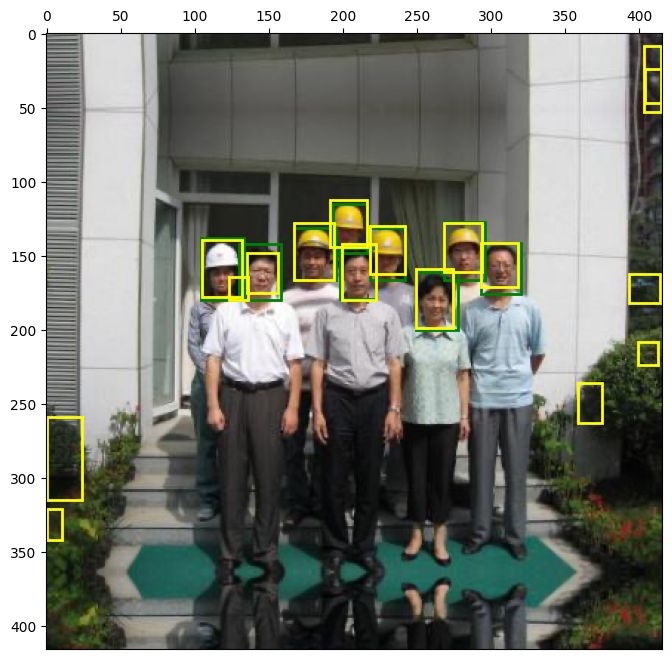

In [ ]:
#validation of the bounding box
import random
image_ref = ("/content/drive/My Drive/helmet_dataset/val/images/hard_hat_workers998.png")
#it is just for reference, input_image

image_path = "/content/drive/My Drive/helmet_dataset/test/images"

file_names = os.listdir(image_path)
image_name = random.choice(file_names)

compare_prediction_with_actual(image_path, image_name, 0.8)
# if you run this cell on CPU, you will encounter an error as it is made to run on GPU.
# if you still want to run on CPU, just remove .cuda() from this line in the funtion defn.:
# img = torch.tensor(img, dtype=torch.float).cuda() #gpu enabled
# similarly, you have to do this for pred box too.

In [ ]:
def pred_box(image_path, image_name, detection_threshold):
    image = plt.imread(image_path+"/"+image_name)
    img = image.copy()
    input_image=(image_path+"/"+image_name)
    # bring color channels to front
    img = np.transpose(img, (2, 0, 1)).astype(np.float32)

    # convert to tensor; tensor([  3., 416., 416.], device='cuda:0')
    img = torch.tensor(img, dtype=torch.float).cuda() #gpu enabled

    # add batch dimension
    img = torch.unsqueeze(img, 0)
    with torch.no_grad(): #forward pass
        outputs = model(img.to(DEVICE))

    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    ''' outputs is a list containing dictionaries. Each dictionary represents the output of the model for a batch of data.
    The new key-value pairs with values on the CPU are collected into a new dictionary, and this dictionary is added to the list.
    moving to CPU bcoz working with visualizations or post-processing steps that may not be available on the GPU'''

    # draw actual bounding boxes (to compare with predicted boxes)
    act_box, act_lbl = get_box_lbl(input_image) #get actual boxes & labels

    #ax = plot_act(image, act_box)

    p_voc_format_act_box={}
    p_voc_format_act_box[image_name] = {'boxes':act_box, 'labels': act_lbl}

    #print(f"Actual number of Boxes: {len(act_box)}")
    #print(f"Actual boxes: {act_box}")

    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) > 0:
        boxes = outputs[0]['boxes'].data.numpy() #converting tensor coordinates to numpy array
        scores = outputs[0]['scores'].data.numpy()
        lbls = outputs[0]['labels'].data.numpy()

        #print(f"Detection Threshold: {detection_threshold}")
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores > detection_threshold].astype(np.int32)

        lbls = lbls[scores > detection_threshold].astype(np.int32)
        #pred_boxes = boxes.copy()

        scores = scores[scores > detection_threshold].astype(np.float32)

        # Returning only the boxes and scores which are above the detection_threshold
        p_voc_format_pred_box = {}
        p_voc_format_pred_box[image_name] = {'boxes':boxes,'scores':scores, 'labels': lbls}

    return p_voc_format_act_box, p_voc_format_pred_box

#**Evaluating the Model**
# By Precision & Recall Metrics
$Precision = \frac{True Positives}{True Positives + False Positives}$

\
$Recall = \frac{True Positives}{True Positives + False Negatives}$

#Hyperparameters

1.   **IoU Threshold = 0.5**
2.   **Confidence Score Threshold = 0.8**



In [ ]:
import numpy as np

def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) between two bounding boxes.

    Parameters:
    - box1, box2: Bounding boxes in the format [x_min, y_min, x_max, y_max].

    Returns:
    - IoU: Intersection over Union value.
    """

    # Calculate the coordinates of the intersection rectangle
    x_min_inter = max(box1[0], box2[0])
    y_min_inter = max(box1[1], box2[1])
    x_max_inter = min(box1[2], box2[2])
    y_max_inter = min(box1[3], box2[3])

    # Calculate the area of the intersection rectangle
    area_inter = max(0, x_max_inter - x_min_inter + 1) * max(0, y_max_inter - y_min_inter + 1)

    # Calculate the area of both bounding boxes
    area_box1 = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    area_box2 = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # Calculate IoU
    iou = area_inter / float(area_box1 + area_box2 - area_inter)

    return iou

In [ ]:
# !(taking one image at a time) & calculating tp,fp & fn for each class
# & accumulating them to list final to calculate precision & recall for each class

# targets_single_image = {...}  # Dictionary containing all actual bounding boxes and labels of a single image
# predictions_single_image = {...}  # Dictionary containing all predicted bounding boxes and labels of a single image

#  we are then separating actual & predicted boxes class-wise and then taking the tp,fp,fn contributions for that specific class

def calculate_values_per_class(targets_single_image, predictions_single_image, num_classes, iou_threshold=0.5):
    list=[]

    for class_idx in range(1, num_classes):  # excluding background class (0)
        true_positives = 0
        false_positives = 0
        false_negatives = 0
        true_boxes, pred_boxes =[], []

        for image_name, pred_data in predictions_single_image.items(): #getting same label pred boxes
          for idx,lbl in enumerate(pred_data['labels']):
            if(lbl==class_idx):
              pred_boxes.append(pred_data['boxes'][idx])

        for image_name, true_data in targets_single_image.items(): #getting same label actual boxes
          for idx,lbl in enumerate(true_data['labels']):
            if(lbl==class_idx):
              true_boxes.append(true_data['boxes'][idx])


        matched_preds = [False] * len(pred_boxes)
        matched_targets = [False] * len(true_boxes)

        for i, pred_box in enumerate(pred_boxes):  #checking whether the predicted box is tp or fp
          for j, true_box in enumerate(true_boxes): # by calculating IoU with actual boxes.
            iou = calculate_iou(pred_box, true_box)
            if iou >= iou_threshold:
             true_positives += 1
             matched_preds[i] = True
             matched_targets[j] = True

        false_positives += len(pred_boxes) - sum(matched_preds)
        false_negatives += len(true_boxes) - sum(matched_targets)
        list1=[true_positives, false_positives, false_negatives]
        list.append(list1)   # finally, sending them list of (#tp,#fp,#fn) to the acuumulator of that class

    # similarly getting lists for all classes.
    return list

In [ ]:
def calculate_precision_recall(list):
  precision_recall_dict={}
  for idx,element in tqdm(enumerate(list), total=len(list)):
    true_positives, false_positives, false_negatives = element
    precision_ = true_positives / (true_positives + false_positives + 1e-6)
    recall_ = true_positives / (true_positives + false_negatives + 1e-6)
    precision = round(precision_, 4)
    recall = round(recall_, 4)
    precision_recall_dict[f'Class {idx+1}'] = {'Precision': precision, 'Recall': recall}

  # Print the results
  print('\n')
  idx=1

  def caps(input_str):
    return input_str.upper()

  for class_name, metrics in precision_recall_dict.items():
    print(caps(CLASS_NAME[idx]))
    print(f"{class_name}: Precision = {metrics['Precision']:.4f}, Recall = {metrics['Recall']:.4f}")
    print()
    idx+=1

  return precision_recall_dict

In [ ]:
list_final=  [[0,0,0],[0,0,0],[0,0,0]] # here each row represents the accumulator of each class.
# which are getting updated by every call of calculate_values_per_class func.

test_image_path = "/content/drive/My Drive/helmet_dataset/test/images"
file_names = os.listdir(test_image_path)

iou_threshold = 0.5
CLASS_NAME = ['__background__', 'helmet', 'head', 'person']
num_classes = len(CLASS_NAME)

for input_image in tqdm(file_names, total=len(file_names)):
  # here, we are taking detection threshold to be 0.8.
  # any detection having score below this will be discarded, i.e bbox with scores more than 0.93
  # will be shown, less than the threshold will not be shown
  act_box_single_image, pred_box_single_image = pred_box(test_image_path, input_image, 0.93)
  lists= calculate_values_per_class(act_box_single_image, pred_box_single_image, num_classes, iou_threshold)
  for idx,list in enumerate(lists):
    for i in range(3):
      list_final[idx][i] += list[i]

In [ ]:
precision_recall_results = calculate_precision_recall(list_final)

100%|██████████| 3/3 [00:00<00:00, 26490.34it/s]



HELMET
Class 1: Precision = 0.7664, Recall = 0.6235

HEAD
Class 2: Precision = 0.5000, Recall = 0.0017

PERSON
Class 3: Precision = 0.0000, Recall = 0.0000



In [ ]:
# Saving the Results into a File so to improve Reproducibility.

import json

# Save to a JSON file
with open('/content/drive/My Drive/helmet_dataset/precision_recall_results_RCNN.json', 'w') as json_file:
    json.dump(precision_recall_results, json_file)

In [ ]:
#If already Calculated once, just run only this cell afterwards, it will load the Evaluation Results stored.
import json

# Load precision-recall results from the JSON file
with open('/content/drive/My Drive/helmet_dataset/precision_recall_results_RCNN.json', 'r') as json_file:
    loaded_precision_recall_results = json.load(json_file)

# Now, loaded_precision_recall_results contains the data from the JSON file
print(loaded_precision_recall_results)

{'Class 1': {'Precision': 0.7664, 'Recall': 0.6235}, 'Class 2': {'Precision': 0.5, 'Recall': 0.0017}, 'Class 3': {'Precision': 0.0, 'Recall': 0.0}}


#**Evaluating the Model** by **mAP @0.5** Metric
# (*Mean Average Precision*)

# Hyperparameter
# **IoU Threshold = 0.5**


# We plot the Precision-Recall Curve (P-R Curve) of a Class by varying the confidence scores and getting the (Precision-Recall) Pairs at that score.

# The Area Under the Curve (AUC) of the (P-R Curve) is defined as the Average Precision(AP) of that Class.
\\
# $AP$ = $ \int_{0}^{1} p(r) \,dr $
\\
# Obviously, Similar AP values would exist if there are multiple classes in the Dataset.

# We take the mean of the AP values of all the Classes and define this quantity to be Mean Average Precision(mAP).
\\
# $mAP$ = $\frac{1}{k} \sum_{i=1}^{k} AP_i $
# where k is the number of classes
\\
# Determination of True Positive would need a IoU Threshold. This can be varied, thus it's a Hyperparameter.

# So, Different APs and mAPs are possible for different IoU Thresholds.

# Generally, it is denoted as mAP@α, where α represents the IoU Threshold taken into consideration.


In [ ]:
import numpy as np

def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) between two bounding boxes.

    Parameters:
    - box1, box2: Bounding boxes in the format [x_min, y_min, x_max, y_max].

    Returns:
    - IoU: Intersection over Union value.
    """

    # Calculate the coordinates of the intersection rectangle
    x_min_inter = max(box1[0], box2[0])
    y_min_inter = max(box1[1], box2[1])
    x_max_inter = min(box1[2], box2[2])
    y_max_inter = min(box1[3], box2[3])

    # Calculate the area of the intersection rectangle
    area_inter = max(0, x_max_inter - x_min_inter + 1) * max(0, y_max_inter - y_min_inter + 1)

    # Calculate the area of both bounding boxes
    area_box1 = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    area_box2 = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # Calculate IoU
    iou = area_inter / float(area_box1 + area_box2 - area_inter)

    return iou

In [ ]:
act_box_all_images= {}
pred_box_all_images= {}

for input_image in file_names:
  act_box_single_image, pred_box_single_image = pred_box(test_image_path, input_image, 0.5)
  act_box_all_images.update(act_box_single_image)
  pred_box_all_images.update(pred_box_single_image)

In [ ]:
print(len(act_box_all_images))
print(len(pred_box_all_images))

500
500


In [ ]:
# Since this requires intensive computation, saving it to use it efficiently
import pickle
# Save to a file
with open('/content/drive/My Drive/helmet_dataset/saved_variable_act.pkl', 'wb') as file:
    pickle.dump(act_box_all_images,file)
with open('/content/drive/My Drive/helmet_dataset/saved_variable_pred.pkl', 'wb') as file:
    pickle.dump(pred_box_all_images,file)

In [ ]:
# If already Calculated once, just run only this cell afterwards, it will load the value of Dicts.
import pickle
with open('/content/drive/My Drive/helmet_dataset/saved_variable_act.pkl', 'rb') as file:
  act_box_all_images=pickle.load(file)
with open('/content/drive/My Drive/helmet_dataset/saved_variable_pred.pkl', 'rb') as file:
  pred_box_all_images=pickle.load(file)

In [ ]:
from collections import OrderedDict
import os
dict1={}

test_image_path ="/content/drive/My Drive/helmet_dataset/test/images"

CLASS_NAME = ['__background__', 'helmet', 'head', 'person']
num_classes = len(CLASS_NAME)

#act_box_all_images = dictionary containg actual bounding boxes and labels for each image , len=500
#pred_box_all_images = dictionary containg predicted bounding boxes, labels & scores for each image , len=500

def calculate_avg_precision_per_class(act_box_all_images, pred_box_all_images, class_idx, iou_threshold=0.5):
  for image_name, y in pred_box_all_images.items():
    for idx,lbl in enumerate(y['labels']):
      if(lbl==class_idx):
        temp= y['scores'][idx]
        dict1[temp]= [ y['boxes'][idx], image_name ]

  #dict1 contains each class specific predictions with scoreas as keys, bboxes and imag_name in a list as values
  # example : dict1= {0.90: [  [10,20,30,40] , 'image_name1' ], 0.86: [ [22,45,60,63] , 'image_name2' ], 0.91: [ [17,12,13,65] , ['image_name] ]

  sorted_dict = OrderedDict(sorted(dict1.items(), reverse = True)) # this sorts dict1 in descending order by their keys, scores here.
  #print(sorted_dict)

  len_gt=0 # for counting the total no. of gt_boxes for that class in the whole dataset(all 500 test images).
  dict_check ={}

  for image_name, y in act_box_all_images.items():
    counter=0
    for idx, lbl in enumerate(y['labels']):
      if(lbl==class_idx):
        counter+=1
        len_gt+=1
      dict_check[image_name] =[0]*counter #creating a check dictionary to track which gt boxes are already matched
    #print(dict_check)

  listr =[] # list for containing all recall values
  listp =[] # list for containing all precision values for corresponding recall value in listr.
  tp= 0     # accumulating #tp values
  fp= 0     # accumulating #tp values
  fn= len_gt - tp # as tp+fn = no. of total gt_boxes

  test_image_path ="/content/drive/My Drive/helmet_dataset/test/images"
  #image_name = 'hard_hat_workers549.png'

  counter =0
  for score,y in sorted_dict.items():
    total_gt_boxes =[]
    input_image = y[1]

    act_box, act_lbl = get_box_lbl(os.path.join(test_image_path,input_image))
    for idx,lbl in enumerate(act_lbl): # collecting all gt_boxes for that lbl in the image of predicted box.
      if(lbl==class_idx):
        total_gt_boxes.append(act_box[idx])
          #print(total_gt_boxes)

          #p_voc_format_act_box[image_name] = {'boxes':boxes, 'labels': lbls}
    temp =0
    iou_max = 0

    for idx, box in enumerate(total_gt_boxes): #calculating IoU of predicted box with all gt_boxes and storing the max IoU value.
      if (dict_check[input_image][idx] !=1):
        val = calculate_iou(y[0], box)
        iou_max= max(iou_max, val)
        if (iou_max==val) : temp = idx

    if (iou_max > iou_threshold):
      #print('hi')
      tp += 1
      dict_check[input_image][temp] = 1
    else:
      fp += 1

    # print(dict_check[input_image][temp])

    #calculating precision & recall for that class on that confidence score threshold
    precision = tp/(tp+fp)
    recall= tp/len_gt
    listp.append(precision)
    listr.append(recall)

  # taking only the max precision values for a particular recall value
  recall_last=0
  final_precision_values= []
  for i,value in enumerate(listr):
    if (value > recall_last):
      recall_last=value
      final_precision_values.append(listp[i])

  #print(final_precision_values)
  precision_tensor = torch.tensor(final_precision_values, dtype=torch.float32) # converting them to tensors.
                                                                               # torch.trapezoid only takes tensor as input.
  interval_width = 1/len_gt #interval length at which (x,y) value pairs are taken.
  ap_value = torch.trapezoid(precision_tensor, dx= interval_width) # calculating area by using Trapezoidal Rule
  #ap_value will be our Average Precision(AP) value for that Class.

  ap_value_scalar = ap_value.item()
  #print(ap_value_scalar)

  return class_idx, ap_value_scalar

In [ ]:
from tqdm import tqdm
# this func. simply calculates the mean average precision by taking the mean of AP values of all the 3 classes.
def mean_avg_precision(act_box, pred_box, num_classes, iou_threshold=0.5):
  avg_precision_dict={}
  for class_idx in tqdm(range(1, num_classes)):
    id, ap_value_scalar = calculate_avg_precision_per_class(act_box_all_images, pred_box_all_images, class_idx, iou_threshold=0.5)
    avg_precision_dict[id] = ap_value_scalar

  final_sum=0
  for sum in avg_precision_dict.values():
    final_sum+=sum

  map_val = round(final_sum/ len(avg_precision_dict), 4)
  map_val = map_val *100

  return map_val

In [ ]:
map_val = mean_avg_precision(act_box_all_images, pred_box_all_images, num_classes, 0.5)

In [ ]:
print(f'Value of mAP@{iou_threshold} = {map_val}%')

Value of mAP@0.5 = 25.34%


In [ ]:
import json

# Save mAP value to a JSON file for reproducibility
with open('/content/drive/MyDrive/helmet_dataset/mAP_value_RCNN.json', 'w') as file:
    json.dump(map_val, file)

In [ ]:
# Load mAP value from JSON file
with open('/content/drive/MyDrive/helmet_dataset/mAP_value_RCNN.json', 'r') as file:
    map_value = json.load(file)

print(f'Value of mAP@{iou_threshold} = {map_value}%')  # Prints the mAP value @0.5 IoU Threshold

Value of mAP@0.5 = 25.34%
